In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

No joblib
no cmocean


In [2]:
print np.log10(0.000001)
print np.log10(10)

-6.0
1.0


In [3]:
# Loading mesh for run

mesh_id    = 'meshArc20'
meshpath   = '/scratch/usr/hbkvsk12/hlrn3_work2/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

/scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc20/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc20/pickle_mesh


In [4]:
tracername = 'VMIX'
first_year = 2014
last_year  = 2014
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc14'
months =np.linspace(0,9,10).astype(int)

In [5]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True       # Saves the interpolated field in netcdf file
delete_old_netcdf = True       # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/'+runid+'/' # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/DIN_budgetv2/'
plot_netcdf       = False      # Reads DIN from the created netcdf file, else it plots the interpolated field (should be the same)

In [6]:
# from derivative import derivative

# bafux_2d, bafuy_2d = derivative(mesh)
# f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)

In [7]:
# ncfile      = meshpath+'Arc20.initial.mesh.diag.nc'
# f           = Dataset(ncfile, 'r')
# NodalVol = f.variables['cluster_vol'][:]
# f.close()


In [8]:
# np.diff(depth)
# mesh.n32[0,0:11]-1
depth = mesh.zlevs
ind_max_depth = 18
depth = depth[0:ind_max_depth]

# Extract 2D fields

In [9]:
for ind in range(0,len(years)):
    depth = mesh.zlevs
    ind_max_depth = 18
    depth = depth[0:ind_max_depth]

    ncfile1       = input_directory+runid+'.'+str(years[ind])+'.oce.diag.nc'
    f1           = Dataset(ncfile1, 'r')
    ncfile2       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f2           = Dataset(ncfile2, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
#     print 'Loading data'
#     din       = f.variables['tr01'][:].mean(axis=0)
#     k     = f1.variables['Kv'][:].mean(axis=0)
    
    MIXN = np.zeros((len(months),len(mesh.x2),len(depth)-2))
    print 'looping over months'
    for mo in months:
        print mo
        
        k    = f1.variables['Kv'][mo,:]
        din    = f2.variables['tr01'][mo,:]
   
        wDN_node = np.zeros((len(mesh.x2),len(depth)-2)) *np.nan
        print 'Looping over nodes'
        for i in range(0,len(mesh.x2)):

            d_ind   = mesh.n32[i,0:ind_max_depth]-1
            d_ind   = d_ind[d_ind > -99]
            depth_avail = depth[:len(d_ind)]
            
            # parametrization #1 (not working)
            #kkz = np.diff(k[d_ind])/np.diff(depth[:ind_max_depth]) * np.diff(din[d_ind])/np.diff(depth[:ind_max_depth])
            
            # parametrization #2 (working)
            #kkz = np.diff(k[d_ind]*din[d_ind])/np.diff(depth[:ind_max_depth])**2
            #kkz[0] = 0
            
            # parametrization #3 (correct one)
            #kkz = k[d_ind[:-1]] * (din[d_ind[1:]] - din[d_ind[:-1]])/(depth_avail[1:] - depth_avail[:-1])
            #kkz[0] = 0 # surface boundary condition
            
            # parametrization #4 (test)
            #kkz = k[d_ind[:-1]] * (din[d_ind[1:]] - din[d_ind[:-1]])/(depth_avail[1:] - depth_avail[:-1])
            #kkz[0] = 0 # surface boundary condition
            #F = np.diff(kkz)/(depth_avail[1:-1] - depth_avail[:-2])
            
            # parametrization #5 (test)
            F1 = ((k[d_ind[:-2]]) * (din[d_ind[1:-1]] - din[d_ind[:-2]]))/(depth_avail[1:-1] - depth_avail[:-2])
            F2 = ((k[d_ind[1:-1]]) * (din[d_ind[2:]] - din[d_ind[1:-1]]))/(depth_avail[2:] - depth_avail[1:-1])
            kkz = (F2 - F1)/(depth_avail[2:] - depth_avail[1:-1])
            kkz[0] = 0 # surface boundary condition
            
            wDN_node[i,:len(d_ind)-2] = kkz

        MIXN[mo,:,:] = wDN_node
        
    tracershape = np.shape(MIXN)

    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = u'VMIX' 
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod2d    = w_nc_fid.createDimension('nod2d', tracershape[1])               # Create dimension: number of 3d nodes
      timed	   = w_nc_fid.createDimension('time', tracershape[0]) 
      depthd    = w_nc_fid.createDimension('depth', tracershape[2]) 

      w_nc_var = w_nc_fid.createVariable('VMIX', 'f4',('time','nod2d','depth'))           # 'DIN' is name of saved variable/ 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'VMIX',\
                          'units': u'mmol/m2/day'})
      w_nc_fid.variables['VMIX'][:] = MIXN   
 
        
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'
    
#     # Loop over depths
#     for d in range(0,100+1,10):
#         ind_lev = np.max(np.argwhere(mesh.zlevs == d))
#         ind_depth = np.array(mesh.n32[:,ind_lev])

2014
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
The netcdf file VMIX.2014.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VMIX.2014.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc14/DIN_budgetv2/


In [171]:
depth = mesh.zlevs
ind_max_depth = 18
depth = depth[0:ind_max_depth]
    
print(np.shape(MIXN))
x = np.nanmean(np.nanmean(MIXN[:,:,:10]*24*3600,axis=0),axis=0)
print(np.shape(x))
print(np.trapz(x,depth[:10]))

(10, 137186, 17)
(10,)
4355.831775665283


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


# Interpolate to Arc12 mesh and save in binaries

In [10]:
np.shape(MIXN)

(10, 137186, 16)

In [11]:
from scipy.interpolate import griddata
mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkvsk12/hlrn3_work2/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh4 = pf.load_mesh(meshpath, usepickle=True, get3d=True)  
#mixing_arc12_int = griddata((mesh.x2, mesh.y2), np.mean(MIXN,axis=0), (mesh4.x2, mesh4.y2), method='nearest') #nearest ?
#np.save('VMIX2014_Arc12_yearly.npy', mixing_arc12_int)

/scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc4.5/pickle_mesh


In [12]:
ncfile = '/scratch/usr/hbkoziel/Arc14/DIN_budgetv2/VMIX.2014.monthly.nc'
f           = Dataset(ncfile, 'r')
MIXN    = f.variables['VMIX'][:,:]
print np.shape(MIXN)

mixing_arc12_int_monthly = np.empty((12,len(mesh4.x2),16))*np.nan
print np.shape(mixing_arc12_int_monthly)
print np.shape(MIXN)
for m in np.arange(0,10):
    print m
    for d in np.arange(0,16):
        #print d
        y = MIXN[m,:,d]
        #print np.shape(y)
        x = griddata((mesh.x2, mesh.y2), y, (mesh4.x2, mesh4.y2), method='nearest')
        #print np.shape(x)
        mixing_arc12_int_monthly[m,:,d] = x
# faking the last couple missing months
mixing_arc12_int_monthly[10,:,:] = mixing_arc12_int_monthly[0,:,:]
mixing_arc12_int_monthly[11,:,:] = mixing_arc12_int_monthly[0,:,:]

np.save('VMIX2014_Arc12_monthly.npy', mixing_arc12_int_monthly)

(10, 137186, 16)
(12, 753179, 16)
(10, 137186, 16)
0
1
2
3
4
5
6
7
8
9


In [13]:
y = MIXN[0,:,0]

In [14]:
print np.mean(k)
print np.min(k)
print np.max(k)

print np.shape(MIXN)
print np.nanmean(MIXN)
print np.nanmin(MIXN)
print np.nanmax(MIXN)

0.032227777
1.0000759e-06
4.0751867
(10, 137186, 16)
1.8503266e-06
-0.24671234
0.24671295


In [15]:
vmix = np.load('VMIX2014_Arc12_monthly.npy')
print np.shape(vmix)
print np.nanmean(vmix)
print np.nanmin(vmix)
print np.nanmax(vmix)

(12, 753179, 16)
1.4512843963600827e-06
-0.20083096623420715
0.15935280919075012


# Vertical profiles

### Global Ocean

(10, 137186, 16)
(18,)


Text(0.5,1,'global Ocean monthly mean turbulent mixing')

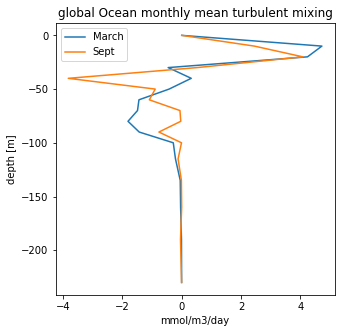

In [21]:
depth = mesh.zlevs
ind_max_depth = 18
depth = depth[0:ind_max_depth]

ncfile = '/scratch/usr/hbkoziel/Arc14/DIN_budgetv2/VMIX.2014.monthly.nc'
f           = Dataset(ncfile, 'r')
MIXN    = f.variables['VMIX'][:,:]
print np.shape(MIXN)
fig = plt.figure(figsize=(5, 5), facecolor='w', edgecolor='k')

print np.shape(depth)
plt.plot((np.nanmean(MIXN[2,:,:]*24*3600,axis=0)),-depth[0:-2],label='March')
plt.plot((np.nanmean(MIXN[8,:,:]*24*3600,axis=0)),-depth[0:-2],label='Sept')

plt.legend()
plt.xlabel('mmol/m3/day')
plt.ylabel('depth [m]')
plt.title('global Ocean monthly mean turbulent mixing')
# plt.plot(np.abs(kkz))

### Arctic Ocean

/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


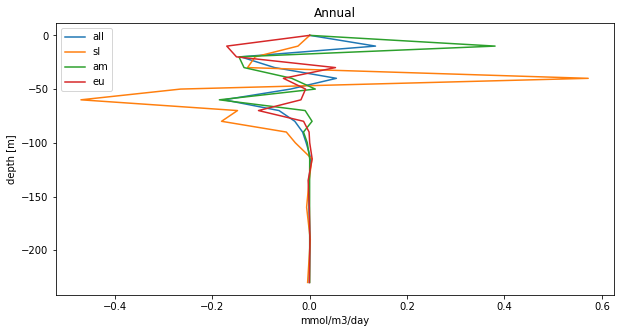

In [22]:
# Visual inspection
ind_all = np.load('index_all.npy')
ind_eu = np.load('index_eurasian.npy')
ind_am = np.load('index_amerasian.npy')
ind_sl = np.load('index_slope.npy')

v_all = np.nanmean(np.nanmean(vmix[:,ind_all,:], axis = 0), axis=0) *24*3600
v_sl = np.nanmean(np.nanmean(vmix[:,ind_sl,:], axis = 0), axis=0) *24*3600
v_am = np.nanmean(np.nanmean(vmix[:,ind_am,:], axis = 0), axis=0) *24*3600
v_eu = np.nanmean(np.nanmean(vmix[:,ind_eu,:], axis = 0), axis=0) *24*3600

fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k')
plt.plot(v_all,-depth[:-2], label= 'all')
plt.plot(v_sl,-depth[:-2], label='sl')
plt.plot(v_am,-depth[:-2],label='am')
plt.plot(v_eu,-depth[:-2],label='eu')

plt.xlabel('mmol/m3/day')
plt.ylabel('depth [m]')
plt.title('Annual')

plt.legend()

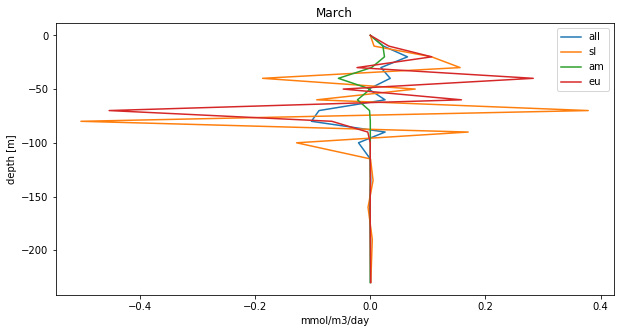

In [23]:
# Visual inspection
ind_all = np.load('index_all.npy')
ind_eu = np.load('index_eurasian.npy')
ind_am = np.load('index_amerasian.npy')
ind_sl = np.load('index_slope.npy')

v_all = np.nanmean((vmix[2,ind_all,:]), axis=0) *24*3600
v_sl = np.nanmean((vmix[2,ind_sl,:]), axis=0) *24*3600
v_am = np.nanmean((vmix[2,ind_am,:]), axis=0) *24*3600
v_eu = np.nanmean((vmix[2,ind_eu,:]), axis=0) *24*3600

fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k')
plt.plot(v_all,-depth[:-2], label= 'all')
plt.plot(v_sl,-depth[:-2], label='sl')
plt.plot(v_am,-depth[:-2],label='am')
plt.plot(v_eu,-depth[:-2],label='eu')

plt.xlabel('mmol/m3/day')
plt.ylabel('depth [m]')
plt.title('March')

plt.legend()

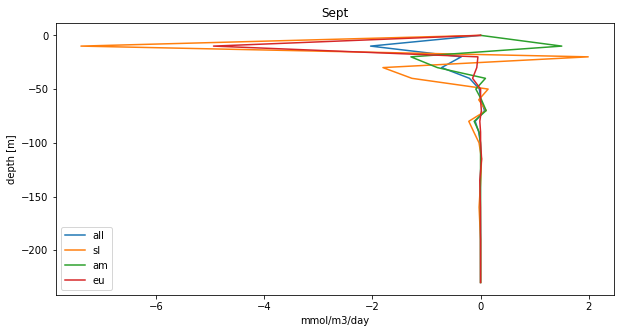

In [24]:
# Visual inspection
ind_all = np.load('index_all.npy')
ind_eu = np.load('index_eurasian.npy')
ind_am = np.load('index_amerasian.npy')
ind_sl = np.load('index_slope.npy')

v_all = np.nanmean((vmix[8,ind_all,:]), axis=0) *24*3600
v_sl = np.nanmean((vmix[8,ind_sl,:]), axis=0) *24*3600
v_am = np.nanmean((vmix[8,ind_am,:]), axis=0) *24*3600
v_eu = np.nanmean((vmix[8,ind_eu,:]), axis=0) *24*3600

fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k')
plt.plot(v_all,-depth[:-2], label= 'all')
plt.plot(v_sl,-depth[:-2], label='sl')
plt.plot(v_am,-depth[:-2],label='am')
plt.plot(v_eu,-depth[:-2],label='eu')

plt.xlabel('mmol/m3/day')
plt.ylabel('depth [m]')
plt.title('Sept')
plt.legend()

# Maps of Fluxes on Original grid

(10, 137186, 16)
(137186,)
(137186,)
For depth 0 model level -0.0 will be used


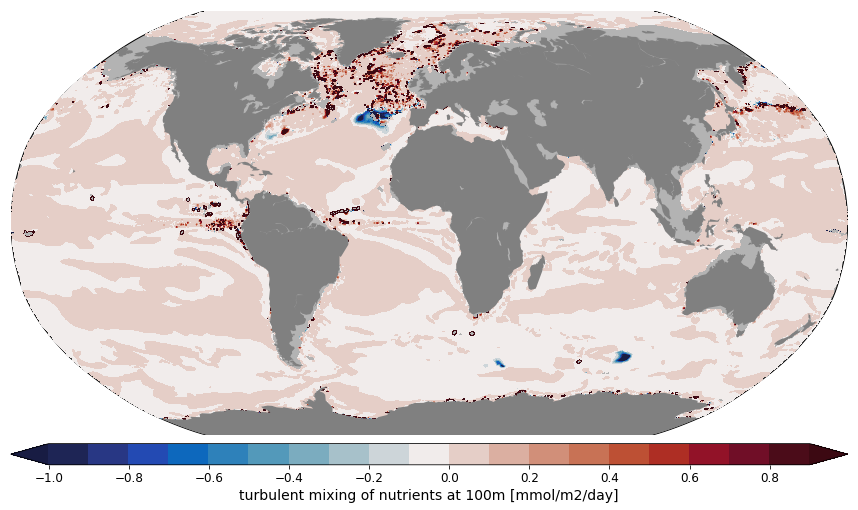

In [25]:
print(np.shape(MIXN))
v = MIXN[2,:,10]*24*3600
#v = np.nanmean(MIXN[2,:,:10], axis =0)*3600*24
print np.shape(v)


# v = np.squeeze(np.nanmean(MIXN[:,:,9], axis =0))

print(np.shape(v))

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-1, 1, .1)

data, elem_no_nan = pf.get_data(v,mesh,0)

ax1      = fig.add_subplot(111)
#m = Basemap(projection='nplaea',boundinglat=45,lon_0=0,resolution='l')
m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'turbulent mixing of nutrients at 100m [mmol/m2/day]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

(137186,)
For depth 0 model level -0.0 will be used


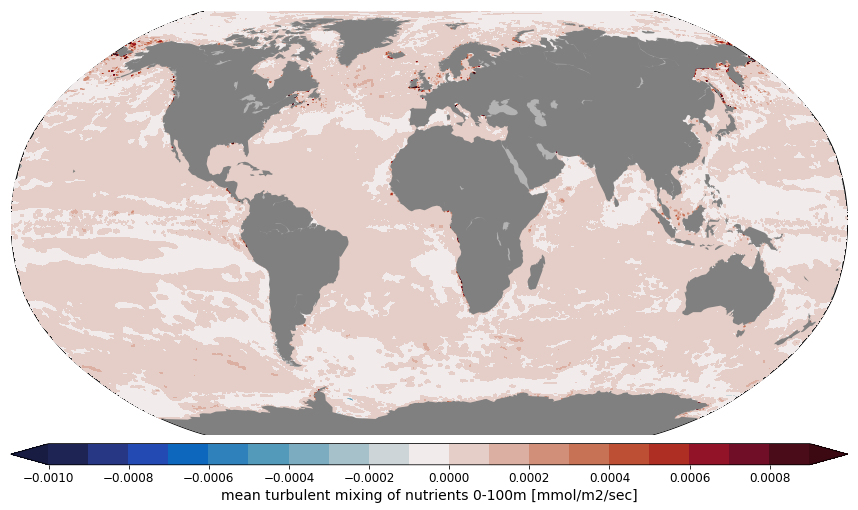

In [26]:
v = np.nanmean(MIXN[:,:,0:10],axis=2)
v = np.nanmean(v, axis =0)

# v = np.squeeze(np.nanmean(MIXN[:,:,9], axis =0))

print(np.shape(v))

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-0.001, 0.001, 0.0001)

data, elem_no_nan = pf.get_data(v,mesh,0)

ax1      = fig.add_subplot(111)
#m = Basemap(projection='nplaea',boundinglat=45,lon_0=0,resolution='l')
m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'mean turbulent mixing of nutrients 0-100m [mmol/m2/sec]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

(137186,)
For depth 0 model level -0.0 will be used


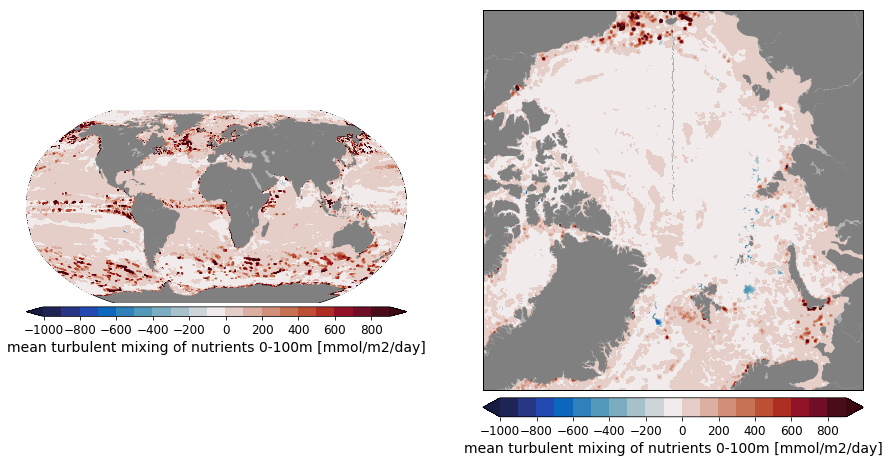

In [32]:
v = np.nansum(MIXN[:,:,0:10],axis=0)*10
v = np.nanmean(v, axis =1)*24*3600

# v = np.squeeze(np.nanmean(MIXN[:,:,9], axis =0))

print(np.shape(v))

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-1000, 1000, 100)

data, elem_no_nan = pf.get_data(v,mesh,0)

ax1      = fig.add_subplot(121)
#m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'mean turbulent mixing of nutrients 0-100m [mmol/m2/day]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

ax2      = fig.add_subplot(122)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
#m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'mean turbulent mixing of nutrients 0-100m [mmol/m2/day]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(137186,)
For depth 0 model level -0.0 will be used


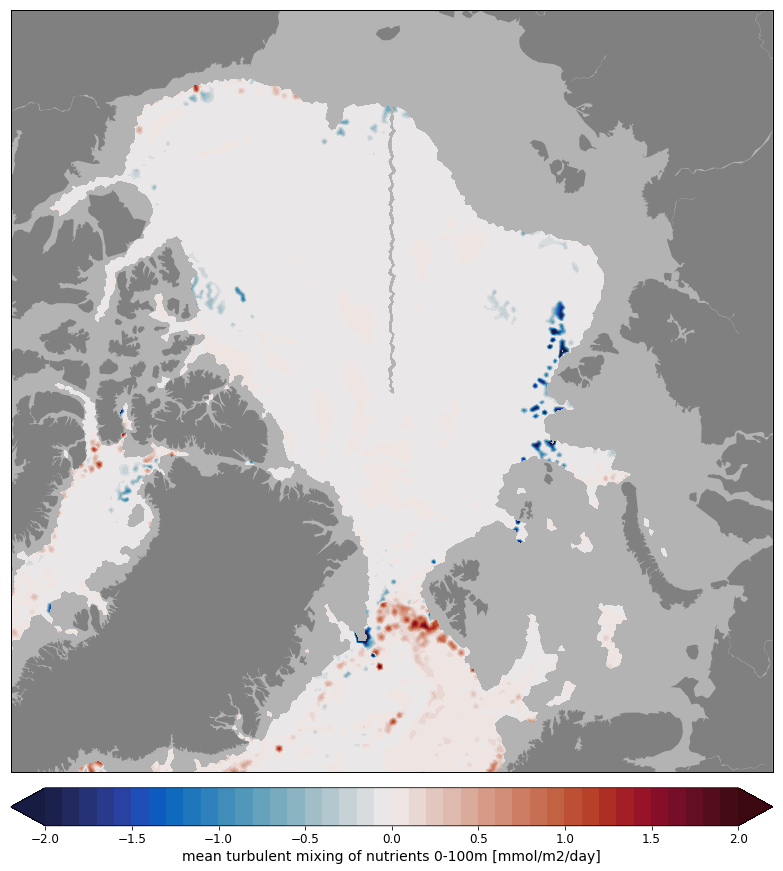

In [29]:
v = np.mean(MIXN[:,:,:],axis=2)
v = np.nanmean(v, axis =0)*24*3600

# v = np.squeeze(np.nanmean(MIXN[:,:,9], axis =0))

print(np.shape(v))

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-2, 2.1, .1)

data, elem_no_nan = pf.get_data(v,mesh,0)

ax1      = fig.add_subplot(111)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
#m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'mean turbulent mixing of nutrients 0-100m [mmol/m2/day]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(137186,)
For depth 0 model level -0.0 will be used


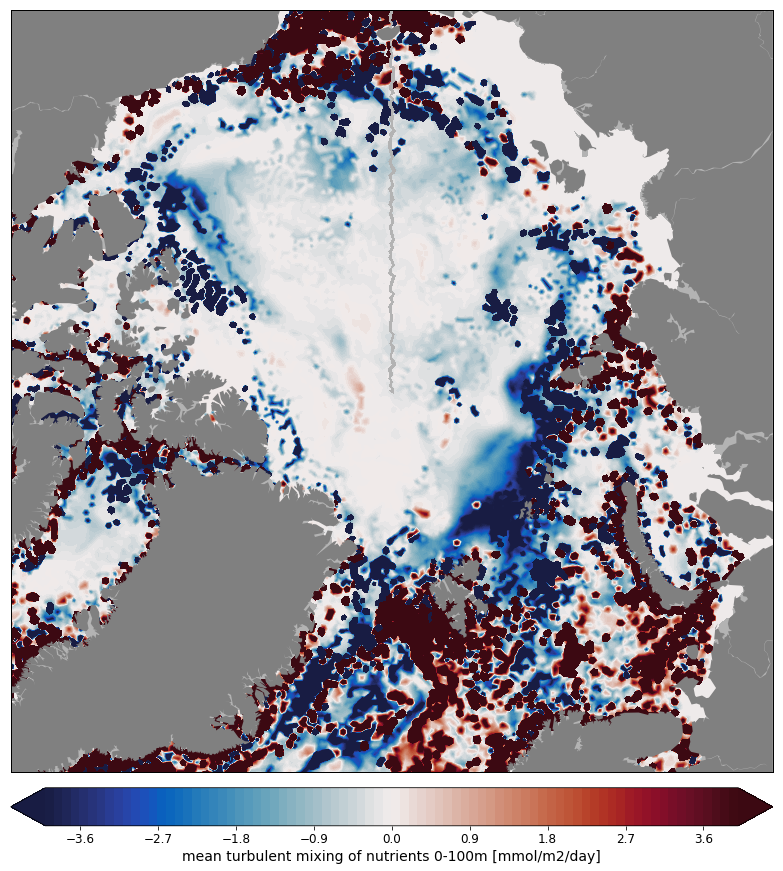

In [31]:
v = np.nanmean(MIXN[:,:,:10], axis =0)*24*3600
v = np.nansum(v, axis=1)*10

print(np.shape(v))

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-4, 4.1, .1)

data, elem_no_nan = pf.get_data(v,mesh,0)

ax1      = fig.add_subplot(111)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
#m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'mean turbulent mixing of nutrients 0-100m [mmol/m2/day]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

# Plot original Kz

(10, 4002637)
/scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc20/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc20/pickle_mesh
(137186,)
For depth 100 model level 100.0 will be used


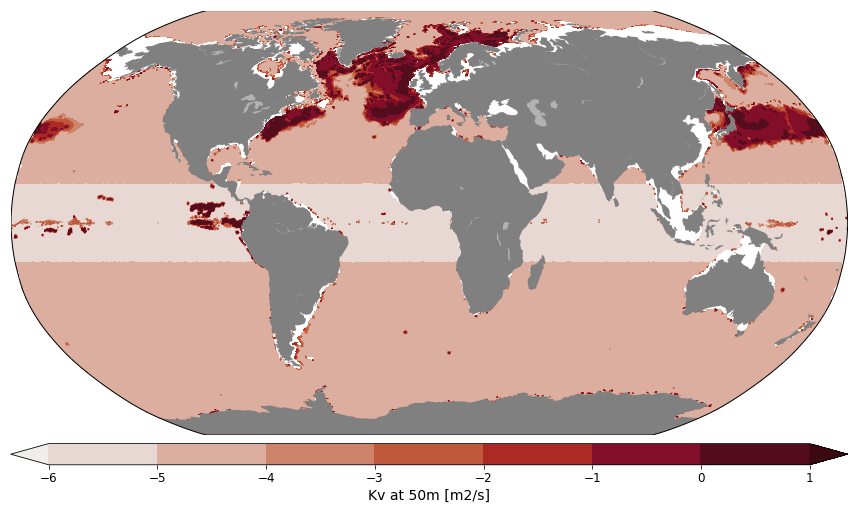

In [69]:
mesh_id    = 'meshArc20'
rund_id = 'Arc14'

input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/Arc14/' # Where the netcdf is saved
ncfile1       = input_directory+'Arc14.2014.oce.diag.nc'
f1           = Dataset(ncfile1, 'r')
k    = f1.variables['Kv'][:]
print np.shape(k)

mesh_id    = 'meshArc20'
meshpath   = '/scratch/usr/hbkvsk12/hlrn3_work2/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)
print np.shape(mesh.x2)

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

kkz = np.mean(k,axis=0)
kkz = k[0,:]

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-6, 2, 1)
data, elem_no_nan = pf.get_data(np.log10(kkz),mesh,100)
ax1      = fig.add_subplot(111)
m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.amp, extend='both')
label = 'Kv at 50m [m2/s]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Annual turbulent mixing of nutrients', fontsize=16)

In [55]:
# plot bottom Kv

kv_annualmean = np.mean(k,axis=0)
kv_annualmean = k[0,:]
kv_bottom = np.zeros(len(mesh.topo))
depth = mesh.zlevs
for i in range(0,len(mesh.topo)):
    ind = np.argmin(np.abs(depth-mesh.topo[i]))
    #print depth[ind]
    d_ind   = mesh.n32[i,ind]-1
    #d_ind[d_ind < -99] = np.nan
    kv_bottom[i] = kv_annualmean[d_ind]
    
print(np.shape(kv_bottom))
print(np.shape(mesh.x2))

(137186,)
(137186,)


For depth 0 model level -0.0 will be used


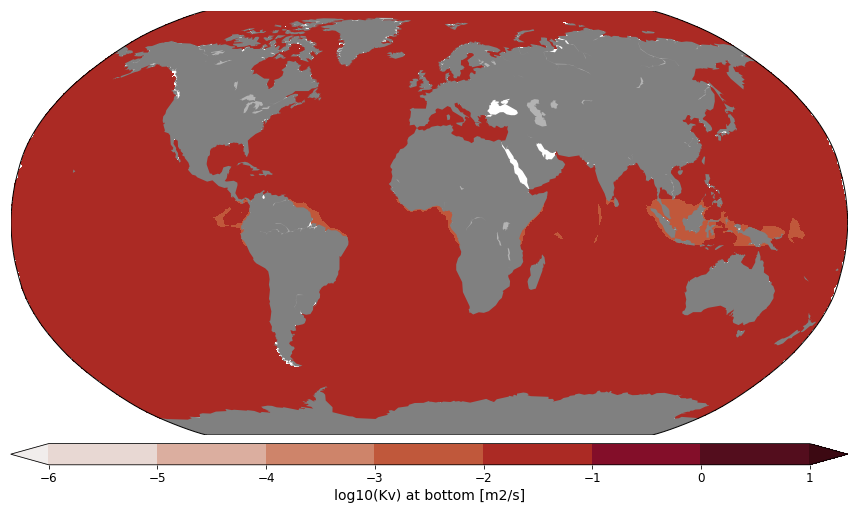

In [56]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-6, 2, 1)
data, elem_no_nan = pf.get_data(np.log10(kv_bottom),mesh,0)
ax1      = fig.add_subplot(111)
m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh.x2, mesh.y2)
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.amp, extend='both')
label = 'log10(Kv) at bottom [m2/s]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Annual turbulent mixing of nutrients', fontsize=16)

(18,)
(10, 4002637)
(137186,)
(10, 18)
(18,)


Text(0.5,1,'global Ocean monthly mean Kv')

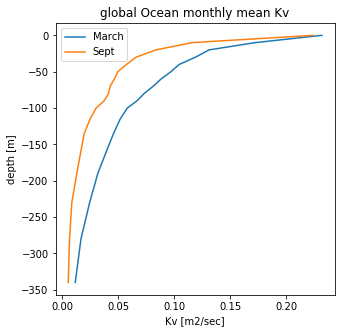

In [93]:
fig = plt.figure(figsize=(5, 5), facecolor='w', edgecolor='k')
# print np.mean(kkz)
# print np.mean(np.abs(kkz))
depth = mesh.zlevs
ind_max_depth = 18
depth = depth[0:ind_max_depth]
print np.shape(depth)
print np.shape(k)
print np.shape(data)

kk = np.empty((10,len(depth))) * np.nan
             
for i in range(0,len(depth)):
    d_ind   = mesh.n32[:,i]-1
    kk[:,i] = np.nanmean(k[:,d_ind],axis=1)
 
print np.shape(kk)
print np.shape(depth[:])
plt.plot((kk[2,:]),-depth,label='March')
plt.plot((kk[8,:]),-depth,label='Sept')

plt.legend()
plt.xlabel('Kv [m2/sec]')
plt.ylabel('depth [m]')
plt.title('global Ocean monthly mean Kv')
# plt.plot(np.abs(kkz))

In [54]:
np.shape(np.nanmean(k[:,d_ind],axis=1))

(10,)